In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import trimesh
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import random
from copy import copy
import h5py
from tqdm.auto import tqdm

#import pytorch3d

In [5]:
import third_party.pvcnn.functional as F
from models.pvcnn2 import PVCNN2,Voxelization

Dataset:

In [6]:
#borrow from https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/dataset.py

synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
cate_to_synsetid = {v: k for k, v in synsetid_to_cate.items()}


class ShapeNetCore(Dataset):

    GRAVITATIONAL_AXIS = 1
    
    def __init__(self, path, cates, split, scale_mode, transform=None):
        super().__init__()
        assert isinstance(cates, list), '`cates` must be a list of cate names.'
        assert split in ('train', 'val', 'test')
        assert scale_mode is None or scale_mode in ('global_unit', 'shape_unit', 'shape_bbox', 'shape_half', 'shape_34')
        self.path = path
        if 'all' in cates:
            cates = cate_to_synsetid.keys()
        self.cate_synsetids = [cate_to_synsetid[s] for s in cates]
        self.cate_synsetids.sort()
        self.split = split
        self.scale_mode = scale_mode
        self.transform = transform

        self.pointclouds = []
        self.stats = None

        self.get_statistics()
        self.load()

    def get_statistics(self):

        basename = os.path.basename(self.path)
        dsetname = basename[:basename.rfind('.')]
        stats_dir = os.path.join(os.path.dirname(self.path), dsetname + '_stats')
        os.makedirs(stats_dir, exist_ok=True)

        if len(self.cate_synsetids) == len(cate_to_synsetid):
            stats_save_path = os.path.join(stats_dir, 'stats_all.pt')
        else:
            stats_save_path = os.path.join(stats_dir, 'stats_' + '_'.join(self.cate_synsetids) + '.pt')
        if os.path.exists(stats_save_path):
            self.stats = torch.load(stats_save_path)
            return self.stats

        with h5py.File(self.path, 'r') as f:
            pointclouds = []
            for synsetid in self.cate_synsetids:
                for split in ('train', 'val', 'test'):
                    pointclouds.append(torch.from_numpy(f[synsetid][split][...]))

        all_points = torch.cat(pointclouds, dim=0) # (B, N, 3)
        B, N, _ = all_points.size()
        mean = all_points.view(B*N, -1).mean(dim=0) # (1, 3)
        std = all_points.view(-1).std(dim=0)        # (1, )

        self.stats = {'mean': mean, 'std': std}
        torch.save(self.stats, stats_save_path)
        return self.stats

    def load(self):

        def _enumerate_pointclouds(f):
            for synsetid in self.cate_synsetids:
                cate_name = synsetid_to_cate[synsetid]
                for j, pc in enumerate(f[synsetid][self.split]):
                    yield torch.from_numpy(pc), j, cate_name
        
        with h5py.File(self.path, mode='r') as f:
            for pc, pc_id, cate_name in _enumerate_pointclouds(f):

                if self.scale_mode == 'global_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = self.stats['std'].reshape(1, 1)
                elif self.scale_mode == 'shape_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1)
                elif self.scale_mode == 'shape_half':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.5)
                elif self.scale_mode == 'shape_34':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.75)
                elif self.scale_mode == 'shape_bbox':
                    pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
                    pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
                    shift = ((pc_min + pc_max) / 2).view(1, 3)
                    scale = (pc_max - pc_min).max().reshape(1, 1) / 2
                else:
                    shift = torch.zeros([1, 3])
                    scale = torch.ones([1, 1])

                pc = (pc - shift) / scale

                self.pointclouds.append({
                    'pointcloud': pc,
                    'cate': cate_name,
                    'id': pc_id,
                    'shift': shift,
                    'scale': scale
                })

        # Deterministically shuffle the dataset
        self.pointclouds.sort(key=lambda data: data['id'], reverse=False)
        random.Random(2020).shuffle(self.pointclouds)

    def __len__(self):
        return len(self.pointclouds)

    def __getitem__(self, idx):
        data = {k:v.clone() if isinstance(v, torch.Tensor) else copy(v) for k, v in self.pointclouds[idx].items()}
        if self.transform is not None:
            data = self.transform(data)
        return data

In [7]:
#https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/data.py
def get_train_val_test_datasets(dataset, train_ratio, val_ratio):
    assert (train_ratio + val_ratio) <= 1
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size
    
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set


def get_train_val_test_loaders(dataset, train_ratio, val_ratio, train_batch_size, val_test_batch_size, num_workers):
    train_set, val_set, test_set = get_train_val_test_datasets(dataset, train_ratio, val_ratio)

    train_loader = DataLoader(train_set, train_batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader


def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [8]:
# Parameters
path_to_shapenet = "data/shapenet.hdf5"
categories = ['airplane']  # Use the categories you're interested in
scale_mode = 'shape_unit'  # or whichever scale mode you want to use
train_batch_size = 128
val_batch_size = 128
num_workers = 0

# Transform
transform = None
# Uncomment and replace with your own transform if needed.
# transform = RandomRotate(180, ['pointcloud'], axis=1)

# Datasets and loaders
train_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='train',
    scale_mode=scale_mode,
    transform=transform,
)
val_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='val',
    scale_mode=scale_mode,
    transform=transform,
)

# Note: The original code uses get_data_iterator, which allows for an infinite loop.
# If you don't want an infinite loop, simply use DataLoader directly as shown below.
train_loader = DataLoader(train_dset, batch_size=train_batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=val_batch_size, num_workers=num_workers)

# If you want the infinite loop, use get_data_iterator instead:
# train_iter = get_data_iterator(train_loader)

Visualize the dataset

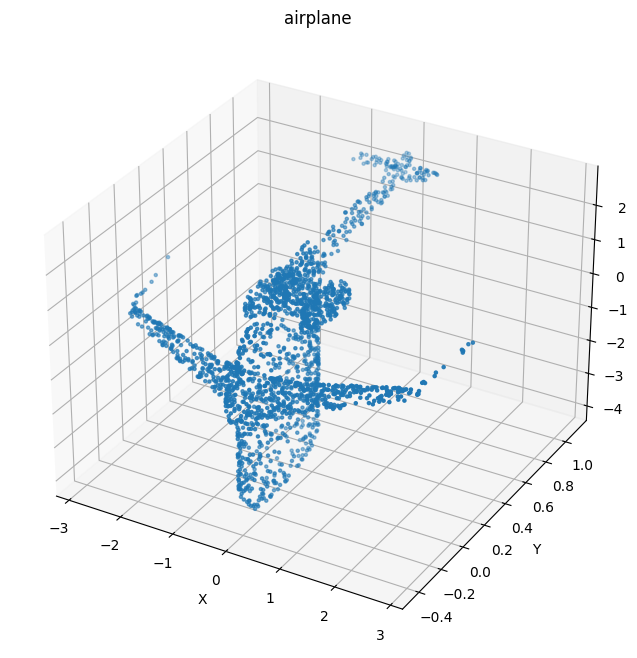

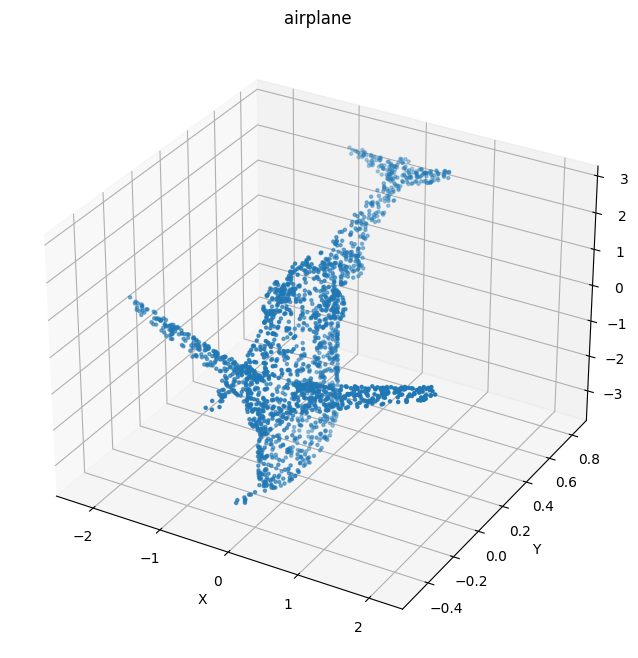

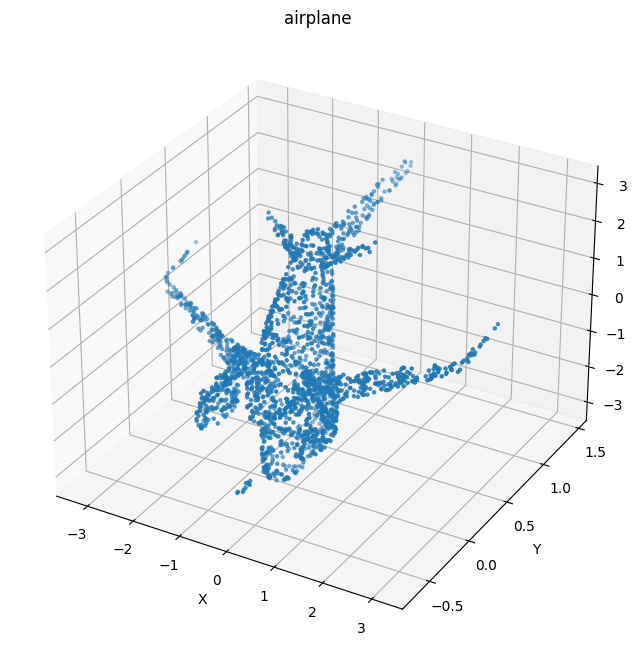

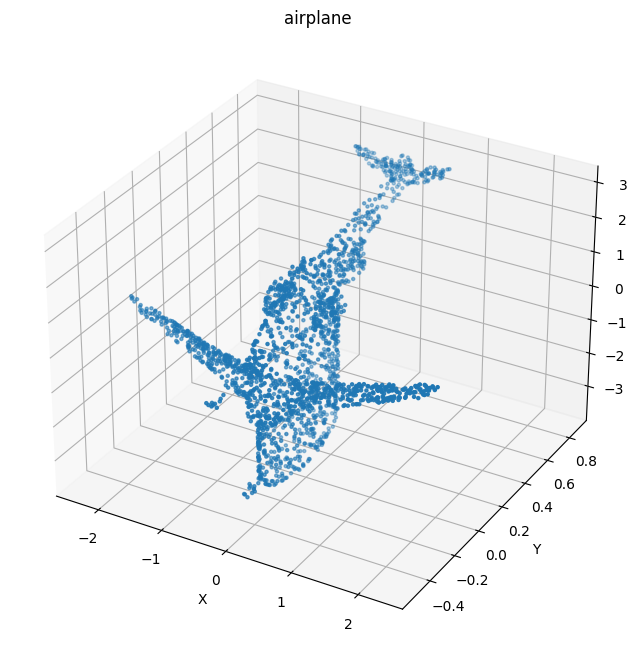

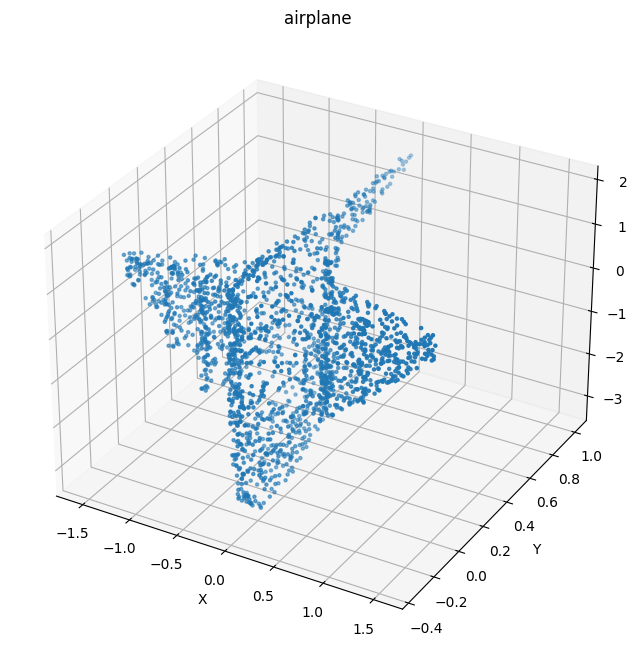

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_pointcloud(points, title=""):
    """Visualize a single point cloud."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_title(title)
    plt.show()

def visualize_dataset(dataset, num_samples=5):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].numpy()
        title = sample['cate']
        visualize_pointcloud(points, title=title)

# Usage:
visualize_dataset(train_dset)

Encoder:

In [10]:
class PVCNN2Encoder(PVCNN2):
    def __init__(self, num_classes, embed_dim, use_att, dropout, extra_feature_channels=3, width_multiplier=1,
                 voxel_resolution_multiplier=1):
        super().__init__(num_classes, embed_dim, use_att, dropout, extra_feature_channels, width_multiplier,
                         voxel_resolution_multiplier)

    def forward(self, inputs, t):
        temb = self.embedf(self.get_timestep_embedding(t, inputs.device))[:, :, None].expand(-1, -1, inputs.shape[-1])

        # inputs : [B, in_channels + S, N]
        coords, features = inputs[:, :3, :].contiguous(), inputs
        coords_list, in_features_list = [], []
        for i, sa_blocks in enumerate(self.sa_layers):
            in_features_list.append(features)
            coords_list.append(coords)
            if i == 0:
                features, coords, temb = sa_blocks((features, coords, temb))
            else:
                features, coords, temb = sa_blocks((torch.cat([features, temb], dim=1), coords, temb))
        in_features_list[0] = inputs[:, 3:, :].contiguous()
        if self.global_att is not None:
            features = self.global_att(features)
        for fp_idx, fp_blocks in enumerate(self.fp_layers):
            features, coords, temb = fp_blocks(
                (coords_list[-1 - fp_idx], coords, torch.cat([features, temb], dim=1), in_features_list[-1 - fp_idx], temb))

        # Don't apply the classification layer for the encoder, return encoded features instead
        return features

In [11]:
class VariationalVoxelPointNetEncoder(nn.Module):
    def __init__(self, num_voxels=32, latent_size=256):  # Set default num_voxels to a sensible value, change if needed
        super(VariationalVoxelPointNetEncoder, self).__init__()
        
        self.num_voxels = num_voxels
        self.encoder = PVCNN2(num_classes=10, embed_dim=128, use_att=True, dropout=0.1)  # Use PVCNN2 as encoder
        
        # Transition layers before latent space calculation
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # For mu and log variance
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_log_var = nn.Linear(256, latent_size)
        
        # Normal distribution and KL divergence
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = F.voxelization(x, self.num_voxels)  # Convert point cloud to voxel
        
        x = self.encoder(x)  # Pass through PVCNN2 encoder
        
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        sigma = torch.exp(0.5 * log_var)
        z = mu + sigma * self.N.sample(mu.shape)
        
        self.kl = (0.5 * (sigma**2 + mu**2 - log_var - 1)).sum()
        
        return z

Decoder:

In [12]:
class VoxelPointNetDecoder(nn.Module):
    def __init__(self, num_voxels=32, latent_size=256, output_points=2048):
        super(VoxelPointNetDecoder, self).__init__()
        
        self.num_voxels = num_voxels
        self.output_points = output_points
        
        # MLP for point cloud generation from latent vector
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, self.num_voxels**3)  # Assuming cubic voxel grid
        self.fc4 = nn.Linear(self.num_voxels**3, self.output_points * 3)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        
        voxel_data = x.view(-1, self.num_voxels, self.num_voxels, self.num_voxels)  # Reshape to voxel data
        
        x = F.trilinear_devoxelization(voxel_data)  # Convert voxel data to point cloud
        
        x = self.fc4(x)
        return x.view(-1, self.output_points, 3)


In [13]:
def chamfer_distance(p1, p2):
    """
    Compute the Chamfer Distance between two point clouds.
    
    Args:
    - p1 (torch.Tensor): A tensor of shape (B, N, D) representing a batch of point clouds, each of which has N points of dimension D.
    - p2 (torch.Tensor): A tensor of the same shape as p1.
    
    Returns:
    - distance (torch.Tensor): A tensor of shape (B,) representing the Chamfer Distance for each pair of point clouds in the batch.
    """
    
    # Compute the pairwise squared distances between points
    # p1 has shape (B, N, D) and p2 has shape (B, M, D)
    # The resulting dists will have shape (B, N, M)
    dists = torch.sum(p1**2, dim=2).unsqueeze(2) + torch.sum(p2**2, dim=2).unsqueeze(1) - 2 * torch.matmul(p1, p2.permute(0, 2, 1))
    
    # For each point in p1, find the closest distance in p2
    min_dists_p1 = torch.min(dists, dim=2)[0]  # Shape (B, N)
    
    # For each point in p2, find the closest distance in p1
    min_dists_p2 = torch.min(dists, dim=1)[0]  # Shape (B, M)
    
    # Combine the two distances by taking the average
    distance = (torch.sum(min_dists_p1, dim=1) + torch.sum(min_dists_p2, dim=1)) / 2
    
    return distance

VAE

In [14]:
class VoxelPointCloudVAE(nn.Module):
    def __init__(self, num_voxels=32, latent_size=256, output_points=2048):
        super(VoxelPointCloudVAE, self).__init__()
        
        self.encoder = VariationalVoxelPointNetEncoder(num_voxels=num_voxels, latent_size=latent_size)
        self.decoder = VoxelPointNetDecoder(num_voxels=num_voxels, latent_size=latent_size, output_points=output_points)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), self.kl


In [15]:
# The vae_loss function needs to be updated since we won't have mu and logvar separately
def vae_loss(reconstructed, original, kl_div, beta=0.0):
    # Reconstruction loss
    recon_loss = chamfer_distance(reconstructed, original).mean()
    
    # Return combined loss
    return recon_loss + beta * kl_div

In [16]:
# Create a VAE
vae = VoxelPointCloudVAE(num_voxels=32, output_points=2048, latent_size=256)

# Forward pass would now look something like this:
# reconstructed, kl_div = vae(point_cloud)

# Compute loss
# loss = vae_loss(reconstructed, point_cloud, kl_div)

Train

In [17]:
def train_vae(model, train_loader, val_loader, optimizer, epochs=100, device='cuda'):
    """
    Trains the VAE model.
    """
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_kl_div, total_recon_loss = 0, 0, 0
        
        # Training
        for i, batch in enumerate(tqdm(train_loader)):
            point_clouds = batch['pointcloud'].to(device)
            
            optimizer.zero_grad()
            reconstructed, kl_div = model(point_clouds)
            
            # Chamfer distance computes loss between two point clouds.
            # Even though we're using a voxel-based VAE, the output and target are still point clouds.
            recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
            combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
            
            combined_loss.backward()
            optimizer.step()
            
            total_train_loss += combined_loss.item()
            total_kl_div += kl_div.item()
            total_recon_loss += recon_loss.item()
            
            # Print batch-level losses
            print(f"Epoch {epoch+1}, Batch {i+1} - Combined Loss: {combined_loss.item():.4f}, KL Div: {kl_div.item():.4f}, Recon Loss: {recon_loss.item():.4f}")
            
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_kl_div = total_kl_div / len(train_loader)
        avg_train_recon_loss = total_recon_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss, total_val_kl_div, total_val_recon_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                point_clouds = batch['pointcloud'].to(device)
                reconstructed, kl_div = model(point_clouds)
                
                recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
                combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
                
                total_val_loss += combined_loss.item()
                total_val_kl_div += kl_div.item()
                total_val_recon_loss += recon_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_kl_div = total_val_kl_div / len(val_loader)
        avg_val_recon_loss = total_val_recon_loss / len(val_loader)
        
        # Print epoch-level average losses
        print(f"\nEpoch: {epoch+1} Summary:")
        print(f"Train Avg Combined Loss: {avg_train_loss:.4f}, Train Avg KL Div: {avg_train_kl_div:.4f}, Train Avg Recon Loss: {avg_train_recon_loss:.4f}")
        print(f"Val Avg Combined Loss: {avg_val_loss:.4f}, Val Avg KL Div: {avg_val_kl_div:.4f}, Val Avg Recon Loss: {avg_val_recon_loss:.4f}\n")


In [18]:
vae = VoxelPointCloudVAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0)

In [19]:
train_vae(vae, train_loader, val_loader, optimizer)

  0%|          | 0/27 [00:00<?, ?it/s]

NameError: name 'voxelization' is not defined

Visualization

In [ ]:
def validate_vae(model, val_loader, device='cuda'):
    """
    Validates the VAE model and returns the average validation loss.
    """
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            point_clouds = batch['pointcloud'].to(device)
            reconstructed, kl_div = model(point_clouds)
            loss = vae_loss(reconstructed, point_clouds, kl_div)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    return avg_val_loss


In [ ]:
def visualize_reconstruction(model, dataset, num_samples=5, device='cuda'):
    """
    Visualize the original and reconstructed point clouds side by side.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    model.eval()

    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].unsqueeze(0).to(device)
        with torch.no_grad():
            reconstructed, _ = model(points)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        points = points.squeeze(0).cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(15, 7))
        
        # Original point cloud
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax1.set_title("Original")
        
        # Reconstructed point cloud
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=5)
        ax2.set_title("Reconstructed")

        plt.show()


In [ ]:
visualize_reconstruction(vae, val_dset) 

Generate a new model

In [ ]:
def sample_from_vae(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    Samples point clouds from the VAE model.
    """
    model.eval()
    with torch.no_grad():
        #
        z_sampled = torch.randn(num_samples, latent_dim).to(device)
        generated_point_clouds = model.decoder(z_sampled)
    return generated_point_clouds


In [ ]:
def visualize_generated_point_clouds(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    Visualizes point clouds generated from the VAE.
    """
    generated_point_clouds = sample_from_vae(model, num_samples, latent_dim, device)
    for i in range(num_samples):
        points = generated_point_clouds[i].cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax.set_title(f"Generated Point Cloud {i+1}")

        plt.show()


In [ ]:
visualize_generated_point_clouds(vae)
